## Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import hashlib
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import os


## Image Segmentation

Processing satellite_1.png...
Converged after 94 iterations.
Video saved to segmentation_video_1.mp4
Processing satellite_2.png...
Video saved to segmentation_video_2.mp4

Final Segmented Images (using last iteration)


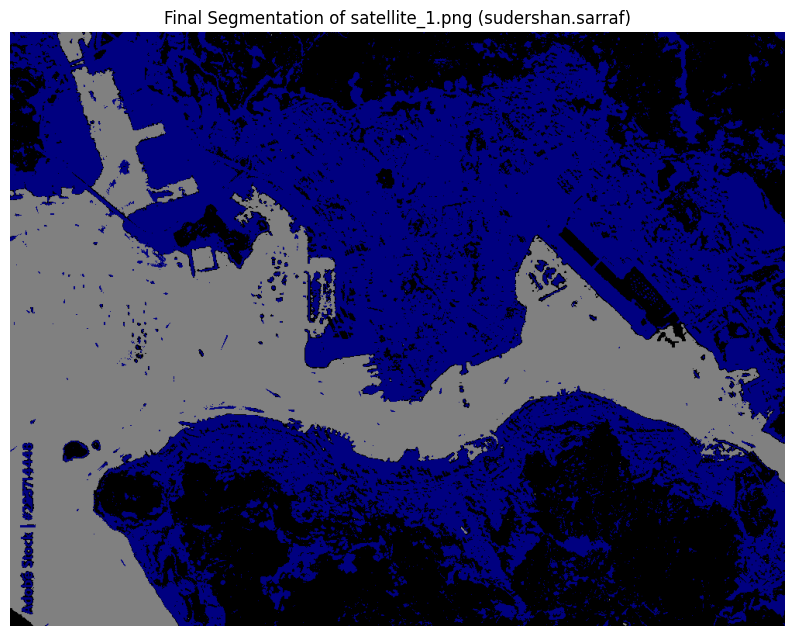

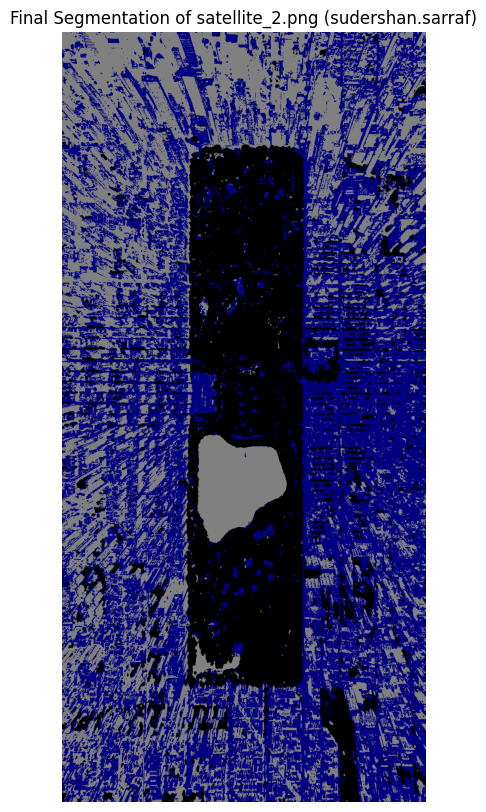

In [22]:
# This line helps prevent a common threading issue with numerical libraries
os.environ['OPENBLAS_NUM_THREADS'] = '1'

# Configuration
username = "sudershan.sarraf"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
np.random.seed(seed)

# Q4.1 Updated GMM Class for Iterative Visualization
class GMM_iterative:
    """
    An updated GMM class that stores parameters at each iteration 
    to facilitate video creation for the segmentation process.
    """
    def __init__(self, k, max_iters=100):
        self.k = k
        self.max_iters = max_iters
        self.weights_history = []
        self.means_history = []
        self.covs_history = []
        self.likelihood_history = []

    def fit(self, X):
        """Trains the GMM and stores the state at each EM iteration."""
        n_samples, n_features = X.shape
        
        # Initialize parameters using K-Means for better starting points.
        kmeans = KMeans(n_clusters=self.k, random_state=seed, n_init='auto').fit(X)
        means = kmeans.cluster_centers_
        counts = np.bincount(kmeans.labels_)
        weights = counts / n_samples
        covs = []
        for i in range(self.k):
            X_k = X[kmeans.labels_ == i]
            if len(X_k) > 1:
                covs.append(np.cov(X_k.T))
            else:
                covs.append(np.eye(n_features) * 1e-6)

        for i in range(self.max_iters):
            # Store current parameters for video frame generation.
            self.weights_history.append(weights.copy())
            self.means_history.append(means.copy())
            self.covs_history.append([c.copy() for c in covs])
            
            memberships = self.getMembership(X, weights, means, covs)
            weights, means, covs = self._m_step(X, memberships)
            likelihood = self.getLikelihood(X, weights, means, covs)
            self.likelihood_history.append(likelihood)

            if i > 0 and abs(self.likelihood_history[i] - self.likelihood_history[i-1]) < 1e-4:
                print(f"Converged after {i + 1} iterations.")
                break
        
        return self

    def getMembership(self, X, weights, means, covs):
        """Calculates the membership probabilities for the E-step."""
        n_samples = X.shape[0]
        memberships = np.zeros((n_samples, self.k))
        for i in range(self.k):
            try:
                pdf = multivariate_normal.pdf(X, means[i], covs[i], allow_singular=True)
                memberships[:, i] = weights[i] * pdf
            except np.linalg.LinAlgError:
                memberships[:, i] = 0

        sum_memberships = np.sum(memberships, axis=1, keepdims=True)
        sum_memberships[sum_memberships == 0] = 1
        return memberships / sum_memberships

    def _m_step(self, X, memberships):
        """Performs the M-step of the EM algorithm."""
        n_samples, n_features = X.shape
        new_weights = np.zeros(self.k)
        new_means = np.zeros((self.k, n_features))
        new_covs = [np.zeros((n_features, n_features)) for _ in range(self.k)]

        for i in range(self.k):
            sum_resp = np.sum(memberships[:, i]) + 1e-9
            new_weights[i] = sum_resp / n_samples
            new_means[i] = np.sum(X * memberships[:, i].reshape(-1, 1), axis=0) / sum_resp
            diff = X - new_means[i]
            new_covs[i] = np.dot((memberships[:, i].reshape(-1, 1) * diff).T, diff) / sum_resp
            new_covs[i] += np.eye(n_features) * 1e-6 # Regularization
            
        return new_weights, new_means, new_covs

    def getLikelihood(self, X, weights, means, covs):
        """Calculates the log-likelihood of the data."""
        n_samples = X.shape[0]
        likelihood = np.zeros((n_samples, self.k))
        for i in range(self.k):
            try:
                likelihood[:, i] = weights[i] * multivariate_normal.pdf(X, means[i], covs[i], allow_singular=True)
            except np.linalg.LinAlgError:
                likelihood[:, i] = 0

        log_likelihood = np.sum(np.log(np.sum(likelihood, axis=1) + 1e-9)) 
        return log_likelihood

# Q4.2 Image Segmentation and Video Visualization
class ImageSegmenter:
    def __init__(self, gmm_model, image_path, username):
        self.gmm = gmm_model
        self.image_path = image_path
        self.username = username
        self.original_image = Image.open(image_path)
        self.image_array = np.array(self.original_image)
        self.pixels = self.image_array.reshape(-1, 3)
        self.height, self.width, _ = self.image_array.shape

    def _add_username_to_plot(self, ax):
        ax.text(0.95, 0.95, self.username, ha='right', va='top', transform=ax.transAxes,
                fontsize=10, color='gray', alpha=0.7)

    def segment_image(self):
        pixels_normalized = self.pixels / 255.0
        self.gmm.fit(pixels_normalized)

    def create_video(self, output_path='segmentation_video.mp4'):
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video = cv2.VideoWriter(output_path, fourcc, 2.0, (self.width * 3, self.height))

        for i in range(len(self.gmm.likelihood_history)):
            frame = self._create_frame(i)
            video.write(frame)

        video.release()
        print(f"Video saved to {output_path}")

    def _create_frame(self, iteration_index):
        panel1 = cv2.cvtColor(self.image_array, cv2.COLOR_RGB2BGR)

        means_iter = self.gmm.means_history[iteration_index]
        weights_iter = self.gmm.weights_history[iteration_index]
        covs_iter = self.gmm.covs_history[iteration_index]
        
        memberships = self.gmm.getMembership(self.pixels / 255.0, weights_iter, means_iter, covs_iter)
        labels = np.argmax(memberships, axis=1)
        
        segmented_pixels = (means_iter[labels] * 255).astype(np.uint8)
        panel2 = segmented_pixels.reshape(self.height, self.width, 3)
        panel2 = cv2.cvtColor(panel2, cv2.COLOR_RGB2BGR)
        
        fig, ax = plt.subplots(figsize=(self.width/100, self.height/100))
        ax.plot(range(iteration_index + 1), self.gmm.likelihood_history[:iteration_index + 1], marker='o')
        ax.set_title('Log-Likelihood vs. Iteration')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Log-Likelihood')
        self._add_username_to_plot(ax)
        ax.grid(True)
        fig.canvas.draw()
        
        buf = fig.canvas.buffer_rgba()
        panel3 = np.asarray(buf)
        panel3 = cv2.cvtColor(panel3, cv2.COLOR_RGBA2BGR)
        plt.close(fig)

        combined_frame = np.hstack((panel1, panel2, panel3))
        return combined_frame

# Execution
print("Processing satellite_1.png...")
gmm1 = GMM_iterative(k=3)
segmenter1 = ImageSegmenter(gmm1, 'Data/satellite_1.png', username)
segmenter1.segment_image()
segmenter1.create_video('segmentation_video_1.mp4')

print("Processing satellite_2.png...")
gmm2 = GMM_iterative(k=3)
segmenter2 = ImageSegmenter(gmm2, 'Data/satellite_2.png', username)
segmenter2.segment_image()
segmenter2.create_video('segmentation_video_2.mp4')

print("\nFinal Segmented Images (using last iteration)")

def show_final_segmentation(segmenter, title):
    """Helper to display the final segmented image with distinct colors."""
    final_means = segmenter.gmm.means_history[-1]
    final_weights = segmenter.gmm.weights_history[-1]
    final_covs = segmenter.gmm.covs_history[-1]

    blue_channel_max_idx = np.argmax(final_means[:, 2])
    green_channel_max_idx = np.argmax(final_means[:, 1])
    
    land_indices = [i for i in range(3) if i not in [blue_channel_max_idx, green_channel_max_idx]]
    land_idx = land_indices[0] if land_indices else -1

    distinct_colors = np.array([
        [128, 128, 128], # Gray for Land/Urban
        [0, 100, 0],     # Dark Green for Vegetation
        [0, 0, 128]      # Dark Blue for Water
    ])
    
    color_map = np.zeros_like(final_means, dtype=np.uint8)
    if land_idx != -1:
        color_map[land_idx] = distinct_colors[0]
    color_map[green_channel_max_idx] = distinct_colors[1]
    color_map[blue_channel_max_idx] = distinct_colors[2]

    final_memberships = segmenter.gmm.getMembership(segmenter.pixels / 255.0, final_weights, final_means, final_covs)
    final_labels = np.argmax(final_memberships, axis=1)
    
    segmented_pixels_final = color_map[final_labels]
    segmented_image_final = segmented_pixels_final.reshape(segmenter.height, segmenter.width, 3)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image_final)
    plt.title(title)
    plt.axis('off')
    plt.show()

show_final_segmentation(segmenter1, f'Final Segmentation of satellite_1.png ({username})')
show_final_segmentation(segmenter2, f'Final Segmentation of satellite_2.png ({username})')



## Segmentation Video for Image 1:
https://iiithydstudents-my.sharepoint.com/:v:/g/personal/sudershan_sarraf_students_iiit_ac_in/EUK9dZa5hsdJq-Cma2XCo2ABCl-uWxBb9UBHjFDfPay-rQ?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=OrqVqE

## Segmentation Video for Image 2:
https://iiithydstudents-my.sharepoint.com/:v:/g/personal/sudershan_sarraf_students_iiit_ac_in/EdFJVeg5_QhEtNGlDtiTOuEBKYgbMX3n4BqUAql_cTffkQ?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=Uohrp5